### Poisson solver for external regions with LGF

In this package we seek to solve the Poisson equation on an external domain.

In [1]:
using Pkg
Pkg.activate("/Users/jeff/Dropbox/MAE250H/julia/final")

"/Users/jeff/Dropbox/MAE250H/julia/final/Project.toml"

The usual set of notebooks

In [4]:
using Revise
using Plots
using LinearAlgebra
using Final

┌ Info: Precompiling Final [69e8fe16-69bc-11e9-02db-a52d5bc2d713]
└ @ Base loading.jl:1186


## Solve for solution of the unit source problem

Solve for $g$
$$ Lg = 1 \equiv \left\{ \begin{array}{l} 1,\quad (i,j) = (0,0)\\ 0,\quad \textrm{other}\end{array} \right. $$

### Set up a domain and grid data

We solve this in index space, where $\Delta x = 1$

In [5]:
NX = 256
NY = 256

256

In [6]:
LX = NX  # length of x side
x0, y0 = 0.0, 0.0  # coordinates of lower left hand corner of domain

(0.0, 0.0)

In [7]:
Δx = LX/NX

1.0

Set the boundary conditions on the wall of the enclosure

In [8]:
xc = 0.5LX; yc = 0.5LX;

In [9]:
ψ∞(x,y) = log.(x.^2+y.^2)/(4π)

ψ∞ (generic function with 1 method)

In [10]:
gL(y,t) = ψ∞(x0-xc,y-yc)
gR(y,t) = ψ∞(x0+LX-xc,y-yc)
gB(x,t) = ψ∞(x-xc,y0-yc)
gT(x,t) = ψ∞(x-xc,y0+LX-yc)

gT (generic function with 1 method)

In [11]:
params = ScalarDirichletParameters(Δx,x0,y0,gL,gR,gB,gT)

ScalarDirichletParameters(1.0, 0.0, 0.0, gL, gR, gB, gT)

#### Solve for g

In [12]:
g = NodeData(NX,NY)
rhs = NodeData(g)
icent = Int(NX/2+1)
jcent = Int(NY/2+1)
rhs[icent,jcent] = 1
apply_bc!(g,0,params)
f̃ = rhs - laplacian(g);
g .= f̃
@time poisson_dirichlet_fft!(g)
apply_bc!(g,0,params);

  2.148609 seconds (6.10 M allocations: 310.242 MiB, 12.15% gc time)


In [13]:
g[icent,jcent]

-0.257343211455081

#### Plot the result

In [14]:
i_n = indices(g,1,interior=false)
j_n = indices(g,2,interior=false)
x_n = xmap(i_n,g,params)
y_n = ymap(j_n,g,params);

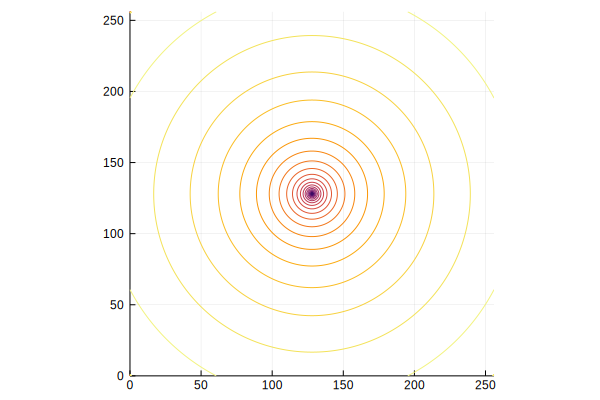

In [15]:
plot(x_n,y_n,transpose(g[i_n,j_n]),legend=:false,ratio=1,levels=range(-0.25,1,length=31))

#### Zoom in...

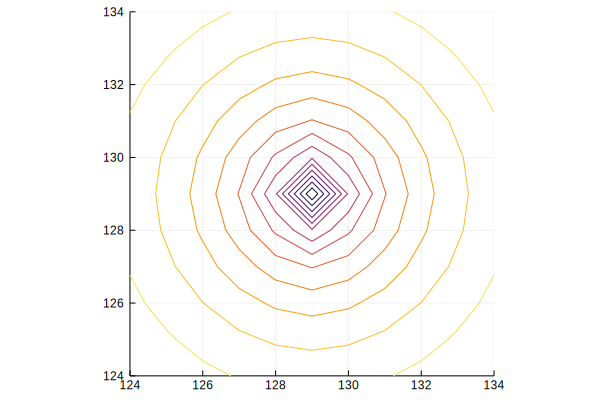

In [16]:
plot(icent.+(-5:5),jcent.+(-5:5),transpose(g[icent.+(-5:5),jcent.+(-5:5)]),legend=:false,ratio=1)

### Test the LGF

In [17]:
lapg = laplacian(g)
println("At center of domain, lap(g) = ",lapg[icent,jcent])

# Remove this center value so we can test that the rest of the field is zero
lapg[icent,jcent] = 0

println("Maximum of other values of lap(g) = ",maximum(abs.(lapg)))

At center of domain, lap(g) = 0.9999999999999991
Maximum of other values of lap(g) = 2.55351295663786e-15


### Now use the LGF to solve a problem

#### Let's define a function that allows us to use it with arbitrary shifts

In [18]:
"""
    L⁻¹!(u,f)

Compute `L⁻¹*f` on infinite domain and return the result in `u`. Note that L⁻¹ is not scaled by grid spacing.
"""
function L⁻¹!(u::NodeData{NX,NY},f::NodeData{NX,NY}) where {NX,NY}
    fill!(u,0.0)
    for j in 1:NY+1, i in 1:NX+1
        for j0 in 1:NY+1, i0 in 1:NX+1
            u[i,j] += f[i0,j0]*g[i-i0+icent,j-j0+jcent]
        end
    end
end

L⁻¹!

Let's test this on a problem with a few localized sources

In [19]:
NX = 128; NY = 128
f = NodeData(NX,NY)
np = 10 # Number of sources
ilim = 10 # This keeps the sources away from the edges
i = rand(ilim:NX-ilim+2,np)
j = rand(ilim:NY-ilim+2,np)
v = rand([-1,1],np).*rand(np)
for p in 1:np
    println("(i,j) = (",i[p],",",j[p],") -> ",v[p])
    f[i[p],j[p]] = v[p]
end
u = NodeData(f);

(i,j) = (54,51) -> 0.7514996140336496
(i,j) = (25,83) -> -0.014000337514946004
(i,j) = (89,39) -> 0.723529354709805
(i,j) = (43,103) -> -0.9493550618329452
(i,j) = (37,21) -> 0.9631006798711941
(i,j) = (11,73) -> 0.5135248801555587
(i,j) = (76,92) -> -0.3821619793101205
(i,j) = (95,71) -> -0.8188497663916525
(i,j) = (36,88) -> -0.4318280925434932
(i,j) = (65,35) -> 0.08855733080540329


In [20]:
@time L⁻¹!(u,f)

 41.297619 seconds (1.66 G allocations: 24.764 GiB, 6.75% gc time)


#### That is pretty slow! Let's plot it:

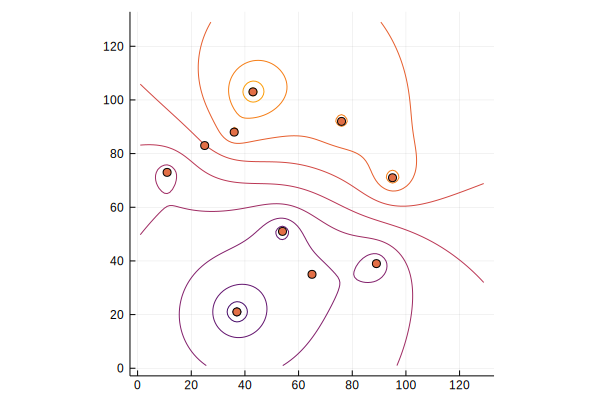

In [21]:
i_n = indices(u,1,interior=false)
j_n = indices(u,2,interior=false)
plot(i_n,j_n,transpose(u[i_n,j_n]),legend=:false,ratio=1)
scatter!(i,j)

#### Evaluate the result

In [22]:
f2 = laplacian(u)
println("L2 Norm of f - Lu = ",norm(f-f2))

L2 Norm of f - Lu = 1.41884308579592e-15


### Now let's try to speed it up

We will use a trick in which we carry out the convolution in Fourier space. First, we need to evaluate the following once in order to generate the inverse operator:

In [23]:
?plan_laplacian

search: plan_laplacian plan_laplacian!



```
plan_laplacian(dims::Tuple,[with_inverse=false],[fftw_flags=FFTW.ESTIMATE],
                      [dx=1.0])
```

Constructor to set up an operator for evaluating the discrete Laplacian on nodal data of dimension `dims`. If the optional keyword `with_inverse` is set to `true`, then it also sets up the inverse Laplacian (the lattice Green's function, LGF). These can then be applied, respectively, with `*` and `\` operations on data of the appropriate size. The optional parameter `dx` is used in adjusting the uniform value of the LGF to match the behavior of the continuous analog at large distances; this is set to 1.0 by default.

Instead of the first argument, one can also supply `w::NodeData` to specify the size of the domain.

# Example

```jldoctest
julia> w = NodeData(5,5);

julia> w[3,3] = 1.0;

julia> L = plan_laplacian(5,5;with_inverse=true)
Discrete Laplacian (and inverse) on a (nx = 6, ny = 6) grid with spacing 1.0

julia> s = L\w
6×6 NodeData{5,5}:
 0.424413  0.38662   0.36338   0.38662   0.424413  0.462207
 0.38662   0.31831   0.25      0.31831   0.38662   0.440376
 0.36338   0.25      0.0       0.25      0.36338   0.430281
 0.38662   0.31831   0.25      0.31831   0.38662   0.440376
 0.424413  0.38662   0.36338   0.38662   0.424413  0.462207
 0.462207  0.440376  0.430281  0.440376  0.462207  0.488075

julia> L*s ≈ w
true
```


In [24]:
L = plan_laplacian(f;with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 129, ny = 129) grid with spacing 1.0

In [26]:
@time u2 = L\f;

  0.008574 seconds (7 allocations: 130.313 KiB)


#### This is a LOT faster. Let's check it

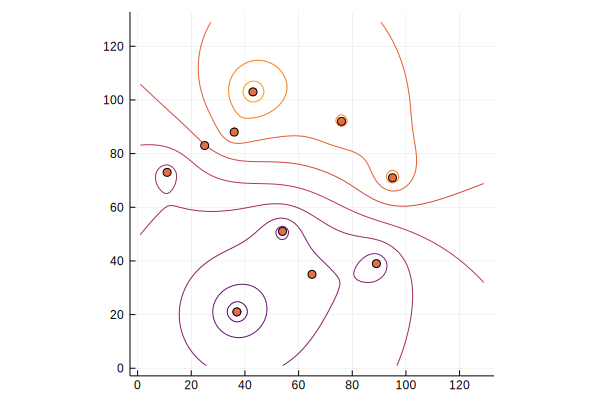

In [27]:
i_n = indices(u,1,interior=false)
j_n = indices(u,2,interior=false)
plot(i_n,j_n,transpose(u2[i_n,j_n]),legend=:false,ratio=1)
scatter!(i,j)

#### The difference between this result and the slow result looks big:

In [28]:
err = norm(u-u2)

0.11426466664095945

#### But it is only a uniform difference that we can easily remove:

In [29]:
norm(u-u2 .- sum(u-u2)/length(u))

2.0372106924860734e-5

#### And the solution is good:

In [30]:
f2 = laplacian(u2)
println("L2 Norm of f - Lu = ",norm(f-f2))

L2 Norm of f - Lu = 1.4016648713525134e-15


## Test the integrating factor

First, we need to set up the integrating factor. We only need to do this once for the grid:

In [31]:
?plan_intfact

search: plan_intfact plan_intfact!



```
plan_intfact(t::Real,dims::Tuple,[fftw_flags=FFTW.ESTIMATE])
```

Constructor to set up an operator for evaluating the integrating factor with real-valued dimensionless time parameter `t`. This can then be applied with the `*` operation on data of the appropriate size.

The `dims` argument can be replaced with `w::NodeData` to specify the size of the domain.

# Example

```jldoctest
julia> w = NodeData(6,6);

julia> w[4,4] = 1.0;

julia> H = plan_intfact(1.0,w)
Integrating factor with parameter 1.0 on a (nx = 7, ny = 7) grid

julia> H*w
7×7 NodeData{6,6}:
 0.000828935  0.00268447  0.00619787  …  0.00619787  0.00268447  0.000828935
 0.00268447   0.00869352  0.0200715      0.0200715   0.00869352  0.00268447
 0.00619787   0.0200715   0.0463409      0.0463409   0.0200715   0.00619787
 0.00888233   0.028765    0.0664124      0.0664124   0.028765    0.00888233
 0.00619787   0.0200715   0.0463409      0.0463409   0.0200715   0.00619787
 0.00268447   0.00869352  0.0200715   …  0.0200715   0.00869352  0.00268447
 0.000828935  0.00268447  0.00619787     0.00619787  0.00268447  0.000828935
```


Okay, let's check it out for $a = 1$

In [32]:
H = plan_intfact(1.0,f)

Integrating factor with parameter 1.0 on a (nx = 129, ny = 129) grid

#### We use the integrating factor as though it were a matrix (although it isn't actually stored as one):

In [33]:
ft = H*f;

Plot it to see what it looks like:

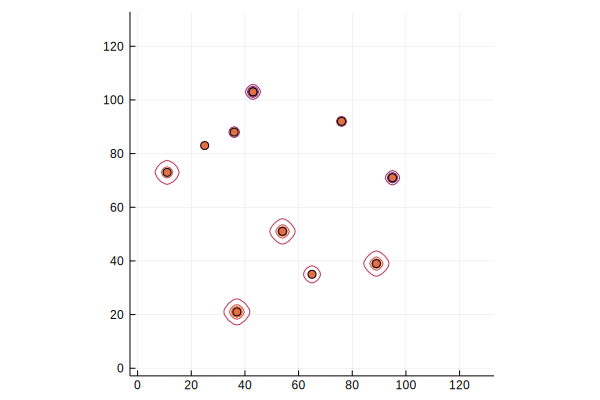

In [34]:
i_n = indices(u,1,interior=false)
j_n = indices(u,2,interior=false)
plot(i_n,j_n,transpose(ft[i_n,j_n]),legend=:false,ratio=1)
scatter!(i,j)

#### Check the inverse

In [38]:
Hinv = plan_intfact(-1.0,f)

Integrating factor with parameter -1.0 on a (nx = 129, ny = 129) grid

In [39]:
f2 = Hinv*(H*f);

In [40]:
norm(f-f2)

1.4135288283419278e-10

Plot the inverted result to check that it is back to the original set of points:

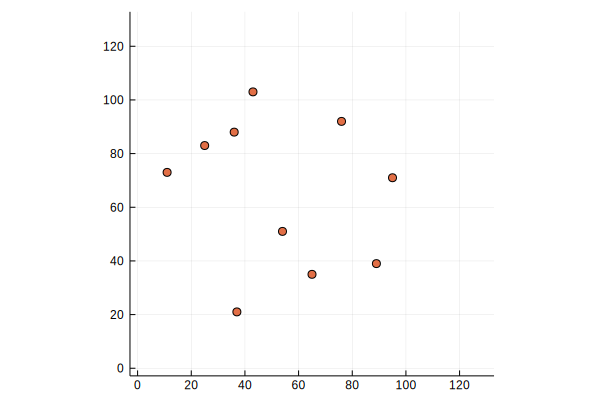

In [41]:
i_n = indices(u,1,interior=false)
j_n = indices(u,2,interior=false)
plot(i_n,j_n,transpose(f2[i_n,j_n]),legend=:false,ratio=1,levels=range(-1,1,length=30))
scatter!(i,j)

#### What does the integrating factor look like?

In [43]:
function create_intfact(a,w::NodeData{NX,NY}) where {NX,NY}

    Nmax = 0
    while abs(intfact(Nmax,0,a)) > eps(Float64)
        Nmax += 1
    end
    return qtab = [intfact(x, y, a) for x in 0:Nmax-1, y in 0:Nmax-1]
end

create_intfact (generic function with 1 method)

This is one quadrant, representing the diffusion from the center after 5 viscous time units

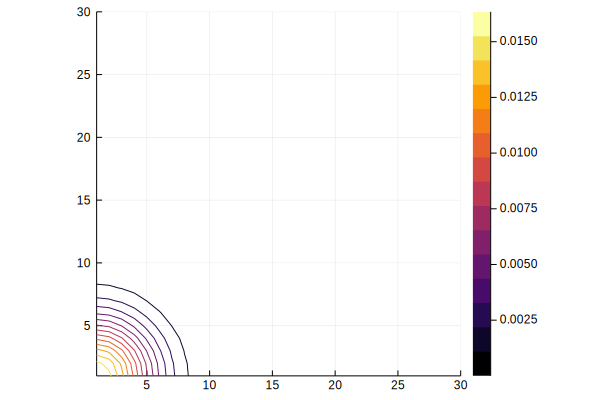

In [44]:
qtab = create_intfact(5.0,f)
contour(qtab,ratio=1)

and here is the inverse, which looks more unusual (and is much larger in magnitude!)

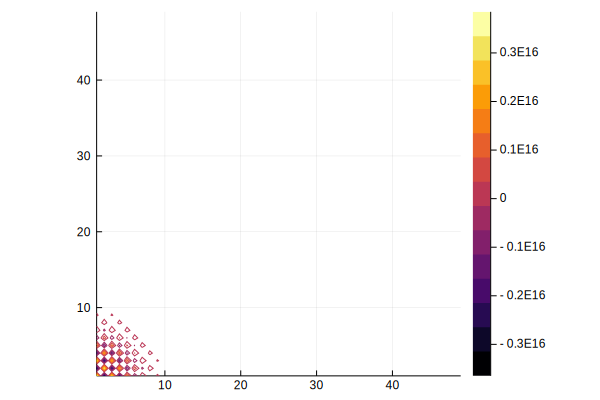

In [45]:
qtabm = create_intfact(-5.0,f)
contour(qtabm,ratio=1)